In [4]:
# Import libraries
import requests
import pandas as pd
pd.options.mode.chained_assignment = None #Mute warnings
import numpy as np
from bs4 import BeautifulSoup
import sys
import matplotlib.pyplot as plt

In [104]:
URL = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt'
r = requests.get(URL).json()['data']
df = pd.DataFrame(r)
df.head()


,cc,core_id,country,guide,logo,nid,rank_display,region,score,stars,title,url
0,US,410,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",294850,1,North America,100,6,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...
1,US,573,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",297282,2,North America,98.7,5,Stanford University,/universities/stanford-university
2,US,253,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",294270,3,North America,98.4,5,Harvard University,/universities/harvard-university
3,US,94,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",294562,4,North America,97.7,5,California Institute of Technology (Caltech),/universities/california-institute-technology-...
4,GB,95,United Kingdom,"<a href=""/where-to-study/europe/united-kingdom...","<img src=""https://www.topuniversities.com/site...",294561,5,Europe,95.6,5,University of Cambridge,/universities/university-cambridge


In [105]:
df_crop = df[['country','rank_display', 'region','title']][:200]
df_crop.head()

,country,rank_display,region,title
0,United States,1,North America,Massachusetts Institute of Technology (MIT)
1,United States,2,North America,Stanford University
2,United States,3,North America,Harvard University
3,United States,4,North America,California Institute of Technology (Caltech)
4,United Kingdom,5,Europe,University of Cambridge


#### Now for each university, we have to find the # of faculty members, students and international students.
For this, we will need the URLs of the respective unis.

In [106]:
suffixes = np.array(df['url'])
urls = []
for suffix in suffixes:
    urls.append('https://www.topuniversities.com' + suffix + '#wurs')

In [107]:
def find_number(soup, tag, my_class):
    try:
        soup.find(tag, class_= my_class).find(tag, class_='number') 
    except: 
        return 0
    
    return int(soup.find(tag, class_= my_class).find(tag, class_='number').text.strip('\n').replace(',','').strip(' '))

In [8]:
staff = []
int_staff = []
students = []
intl_students = []
i = 1

for url in urls[:200]:
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
   
    faculty_staff = find_number(soup,'div','faculty-main wrapper col-md-4')
    intl_faculty_staff = find_number(soup, 'div', 'inter faculty')
    students_ = find_number(soup, 'div', 'students-main wrapper col-md-4')
    int_students = find_number(soup, 'div','int-students-main wrapper col-md-4')
    
    staff.append(faculty_staff)
    int_staff.append(intl_faculty_staff)
    students.append(students_)
    intl_students.append(int_students)

In [108]:
staff_s = pd.Series(staff)
int_staff_s = pd.Series(int_staff)
students_s = pd.Series(students)
intl_students_s = pd.Series(intl_students)

In [109]:
df_crop['students'] = students_s
df_crop['intl_students'] = intl_students_s
df_crop['staff'] = staff_s
df_crop['intl_staff'] = int_staff_s

df_a = df_crop.copy()
df_a['students:staff ratio'] = students_s.divide(staff_s).round(3)
df_a['ratio intl students'] = (intl_students_s.divide(students_s).round(5))*100

In [110]:
# a. Ranking by student:staff ratio
df_a.sort_values(['students:staff ratio'], ascending = True, inplace = True)
df_a.set_index(pd.Series(list(range(1,201))), inplace = True)
del df_a['rank_display']
df_a[['country','title','students:staff ratio']].head()

,country,title,students:staff ratio
1,United States,California Institute of Technology (Caltech),2.366
2,United States,Yale University,2.511
3,United Kingdom,University of Oxford,2.921
4,United Kingdom,University of Cambridge,3.419
5,United States,Johns Hopkins University,3.619


In [111]:
# b. Ratio of international students
df_a.sort_values(['ratio intl students'], ascending = False, inplace = True)
df_a = df_a.set_index(pd.Series(list(range(1,201))))
df_a[['country','title','ratio intl students']].head()

,country,title,ratio intl students
1,United Kingdom,London School of Economics and Political Scien...,69.139
2,Switzerland,Ecole Polytechnique Fédérale de Lausanne (EPFL),57.005
3,United Kingdom,Imperial College London,54.357
4,Netherlands,Maastricht University,50.253
5,United States,Carnegie Mellon University,47.806


In [129]:
# c. Aggregating by country
df_c = df_crop.copy()
df_c = df_c.groupby('country').sum()
df_c.head()

,students,intl_students,staff,intl_staff
country,,,,
Argentina,122301,27109,16421,3165
Australia,301994,106359,22034,11382
Austria,63446,19667,4117,1572
Belgium,115067,17013,8046,2187
Brazil,92283,3052,7550,388


## N.B:
#### After summing up the Dataframe by country, it is crucial to recalculate the ratios (international students, as well as students per staff). That is because if we apply the mean() function, we will get the mean percentage of, let's say, international students, based on the mean of all percentages of international students, which does not make much sense since the number of students may be very different from a country to another.

In [ ]:
df_c['students:staff ratio'] = df_c['students'].divide(df_c['staff']).round(3)
df_c['ratio intl students'] = (df_c['intl_students'].divide(df_c['students']).round(5))*100

In [113]:
# Ranking by increasing ratio between faculty members and students (best first), by country (TOP 10)
df_c.sort_values('students:staff ratio', ascending = True)[['students:staff ratio']][:20] 

,students:staff ratio
country,
Russia,4.506
Denmark,5.641
Saudi Arabia,5.687
Singapore,6.191
Malaysia,6.498
Japan,6.558
South Korea,7.056
Switzerland,7.121
United Kingdom,7.301


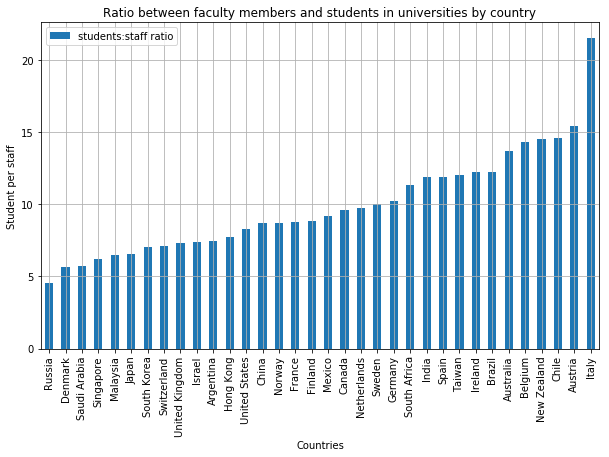

In [128]:
df_c[['students:staff ratio']].sort_values('students:staff ratio', ascending = True)\
.plot.bar(figsize=(10,6),title ='Ratio between faculty members and students in universities by country', grid = True)
plt.xlabel('Countries')
plt.ylabel('Student per staff')
plt.show()

#### We can see that Russia takes the lead in terms of ratio between faculty members and students (lowest), followed by Denmark and Saudi Arabia. Whereas Chile, Austria and Italy come up at last positions.

In [115]:
# Ranking by descreasing ratio of international students, by country
df_c.sort_values('ratio intl students', ascending = False)[['ratio intl students']][:10]

,ratio intl students
country,
Australia,35.219
United Kingdom,34.170
Hong Kong,31.075
Austria,30.998
Switzerland,30.240
Singapore,27.654
Canada,26.016
New Zealand,25.822
Ireland,23.530


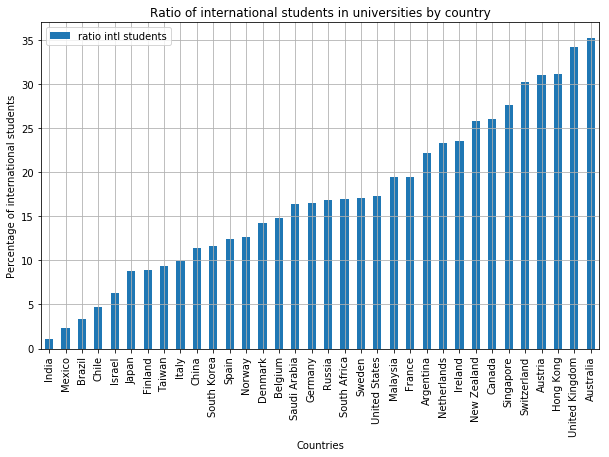

In [120]:
df_c[['ratio intl students']].sort_values('ratio intl students', ascending = True)\
.plot.bar(figsize=(10,6),title ='Ratio of international students in universities by country', grid = True)
plt.xlabel('Countries')
plt.ylabel('Percentage of international students')
plt.show()

In [137]:
# d. Aggregating by region
df_d = df_crop.copy()
df_d = df_d.groupby('region').sum()
df_d

,students,intl_students,staff,intl_staff
region,,,,
Africa,19593,3325,1733,379
Asia,807003,110100,106734,25462
Europe,1957251,449364,218358,67598
Latin America,435750,36871,45382,5648
North America,1546353,292116,182123,43836
Oceania,350167,118798,25347,12786


#### As explained earlier, we proceed to calculate the new ratios by the same manner after summing up the DataFrame by country.

In [138]:
df_d['students:staff ratio'] = df_d['students'].divide(df_d['staff']).round(3)
df_d['ratio intl students'] = (df_d['intl_students'].divide(df_d['students']).round(5))*100
df_d

,students,intl_students,staff,intl_staff,students:staff ratio,ratio intl students
region,,,,,,
Africa,19593,3325,1733,379,11.306,16.970
Asia,807003,110100,106734,25462,7.561,13.643
Europe,1957251,449364,218358,67598,8.963,22.959
Latin America,435750,36871,45382,5648,9.602,8.462
North America,1546353,292116,182123,43836,8.491,18.891
Oceania,350167,118798,25347,12786,13.815,33.926


In [134]:
# Ranking by increasing ratio between faculty members and students (best first), by region
df_d.sort_values('students:staff ratio', ascending = True, inplace = True)
df_d[['students:staff ratio']]

,students:staff ratio
region,
Asia,7.561
North America,8.491
Europe,8.963
Latin America,9.602
Africa,11.306
Oceania,13.815


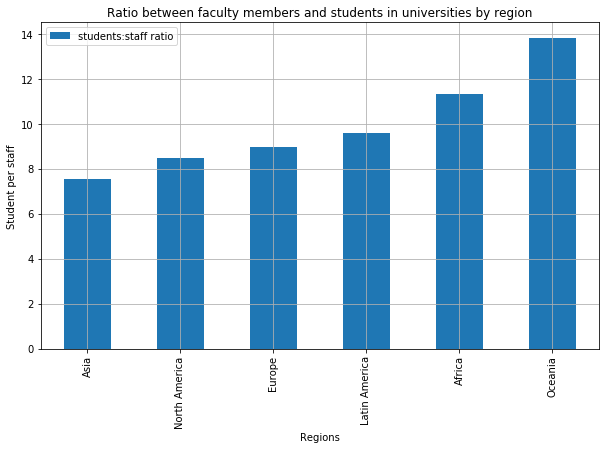

In [135]:
df_d[['students:staff ratio']].\
plot.bar(figsize=(10,6),title ='Ratio between faculty members and students in universities by region', grid = True)
plt.xlabel('Regions')
plt.ylabel('Student per staff')
plt.show()

In [136]:
# Ranking by descreasing ratio of international students, by region
df_d.sort_values('ratio intl students', ascending = False)[['ratio intl students']]

,ratio intl students
region,
Oceania,33.926
Europe,22.959
North America,18.891
Africa,16.970
Asia,13.643
Latin America,8.462


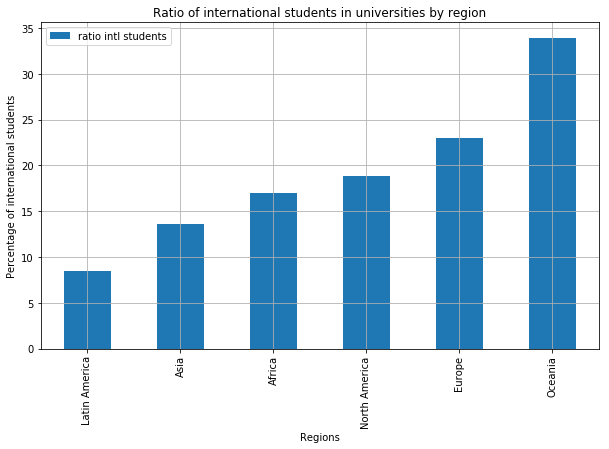

In [127]:
df_d[['ratio intl students']].sort_values('ratio intl students', ascending = True)\
.plot.bar(figsize=(10,6),title ='Ratio of international students in universities by region', grid = True)
plt.xlabel('Regions')
plt.ylabel('Percentage of international students')
plt.show()

## (comment findings)

## EXERCISE 2

In [72]:
def get_numbers(soup):
    try:
        number_staff_total = soup.find('div', class_='faculty-main wrapper col-md-4').find('div', class_='total faculty').find('div', class_='number').text.strip(' ').strip('\n').replace(',','')
    except AttributeError : number_staff_total = '0' 
    try:
        number_staff_inter = soup.find('div', class_='faculty-main wrapper col-md-4').find('div', class_='inter faculty').find('div', class_='number').text.strip(' ').strip('\n').replace(',','')
    except AttributeError :  number_staff_inter = 0
    try:
        number_student_total = soup.find('div', class_='students-main wrapper col-md-4').find('div', class_='number').text.strip(' ').strip('\n').replace(',','')
    except AttributeError :  number_student_total = '0'
    try:
        number_student_inter = soup.find('div', class_='int-students-main wrapper col-md-4').find('div', class_='number').text.strip(' ').strip('\n').replace(',','')       
    except AttributeError: number_student_inter = '0' 
                                                                                                                                              
    return pd.Series([number_staff_total, number_staff_inter, number_student_total, number_student_inter])

df_numbers_info=pd.DataFrame()

serie_staff_total=pd.Series()
serie_staff_inter=pd.Series()
serie_student_total=pd.Series()
serie_student_inter=pd.Series()

for link_uni in df['url']:
    r=requests.get('https://www.topuniversities.com'+link_uni)
    soup = BeautifulSoup(r.text, 'html.parser')
    serie=get_numbers(soup)
    serie_staff_total=serie_staff_total.append(pd.Series(serie[0])) 
    serie_staff_inter=serie_staff_inter.append(pd.Series(serie[1])) 
    serie_student_total=serie_student_total.append(pd.Series(serie[2])) 
    serie_student_inter=serie_student_inter.append(pd.Series(serie[3])) 

df['Total staffs']=serie_staff_total.values
df['Total international staffs']=serie_staff_inter.values
df['Total students']=serie_student_total.values
df['Total international students']=serie_student_inter.values

df.set_index('title')

,cc,core_id,country,guide,logo,nid,rank_display,region,score,stars,url,Total staffs,Total international staffs,Total students,Total international students
title,,,,,,,,,,,,,,,
Massachusetts Institute of Technology (MIT),US,410,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",294850,1,North America,100,6,/universities/massachusetts-institute-technolo...,2982,1679,11067,3717
Stanford University,US,573,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",297282,2,North America,98.7,5,/universities/stanford-university,4285,2042,15878,3611
Harvard University,US,253,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",294270,3,North America,98.4,5,/universities/harvard-university,4350,1311,22429,5266
California Institute of Technology (Caltech),US,94,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",294562,4,North America,97.7,5,/universities/california-institute-technology-...,953,350,2255,647
University of Cambridge,GB,95,United Kingdom,"<a href=""/where-to-study/europe/united-kingdom...","<img src=""https://www.topuniversities.com/site...",294561,5,Europe,95.6,5,/universities/university-cambridge,5490,2278,18770,6699
University of Oxford,GB,478,United Kingdom,"<a href=""/where-to-study/europe/united-kingdom...","<img src=""https://www.topuniversities.com/site...",294654,6,Europe,95.3,5,/universities/university-oxford,6750,2964,19720,7353
UCL (University College London),GB,365,United Kingdom,"<a href=""/where-to-study/europe/united-kingdom...","<img src=""https://www.topuniversities.com/site...",294014,7,Europe,94.6,None,/universities/ucl-university-college-london,6345,2554,31080,14854
Imperial College London,GB,356,United Kingdom,"<a href=""/where-to-study/europe/united-kingdom...","<img src=""https://www.topuniversities.com/site...",294030,8,Europe,93.7,None,/universities/imperial-college-london,3930,2071,16090,8746
University of Chicago,US,120,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",294536,9,North America,93.5,5,/universities/university-chicago,2449,635,13557,3379


# Exercise 3